In [1]:
# 시험환경 세팅 (코드 변경 X)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def exam_data_load(df, target, id_name="", null_name=""):
    if id_name == "":
        df = df.reset_index().rename(columns={"index": "id"})
        id_name = 'id'
    else:
        id_name = id_name
    
    if null_name != "":
        df[df == null_name] = np.nan
    
    X_train, X_test = train_test_split(df, test_size=0.2, random_state=2021)
    
    y_train = X_train[[id_name, target]]
    X_train = X_train.drop(columns=[target])

    
    y_test = X_test[[id_name, target]]
    X_test = X_test.drop(columns=[target])
    return X_train, X_test, y_train, y_test 
    
df = pd.read_csv("../input/insurance/insurance.csv")
X_train, X_test, y_train, y_test = exam_data_load(df, target='charges')

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1070, 7), (268, 7), (1070, 2), (268, 2))

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# RMSE 함수 생성
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

le = LabelEncoder()
ss = StandardScaler()

# 범주형 변수 컬럼 인코딩
o_cols = ['sex', 'smoker', 'region']

for col in o_cols:
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

# 수치형 변수 컬럼 스케일링(표준화)
n_cols = ['age', 'bmi', 'children']

ss.fit_transform(X_train[n_cols])
ss.transform(X_test[n_cols])
y = y_train.charges

# 데이터 셋 분할
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, test_size = 0.15, random_state = 1999)

# 학습 모델 설정
rf = RandomForestRegressor()
xgb = XGBRegressor()

# 학습
rf.fit(X_tr, y_tr)
xgb.fit(X_tr, y_tr)

# 학습 점수 계산
y_pred_rf = rf.predict(X_val)
print('랜덤 포레스트')
print("MRSE: ", rmse(y_val, y_pred_rf))
print("R2 score: ", r2_score(y_val, y_pred_rf))

print("\n")

y_pred_xgb = xgb.predict(X_val)
print('XGBoost')
print("MRSE: ", rmse(y_val, y_pred_xgb))
print("R2 score: ", r2_score(y_val, y_pred_xgb))

print('\n')

# 랜덤 포레스트의 점수가 높으므로 최종 모델로 선택
model = RandomForestRegressor()
model.fit(X_tr, y_tr)
y_pred = model.predict(X_test)

# 답안 제출
pd.DataFrame({"id":X_test.id, "charges":y_pred}).to_csv('000000000.csv', index=False)
result = pd.read_csv('000000000.csv')
display(result.head(10))

print("--채점--")
print("MRSE: ", rmse(y_test.charges, y_pred))
print("R2 score: ", r2_score(y_test.charges, y_pred))

랜덤 포레스트
MRSE:  4348.44064998176
R2 score:  0.8765969463068122


XGBoost
MRSE:  4614.445063648549
R2 score:  0.8610374507015008




,id,charges
0,1088,15344.082293
1,1157,6588.656157
2,1267,34814.285842
3,506,8365.611171
4,659,21408.458570
5,817,3979.369311
6,1050,12396.277911
7,685,15878.489752
8,1027,2367.059221
9,62,16951.175734


--채점--
MRSE:  4666.512139244192
R2 score:  0.8455507311173138


# 풀이
---

# EDA

In [3]:
X_train.head()

,id,age,sex,bmi,children,smoker,region
209,209,40,1,41.230,1,0,0
540,540,34,0,38.000,3,0,3
747,747,19,1,21.755,0,0,1
39,39,60,1,39.900,0,1,3
640,640,33,1,42.400,5,0,3


In [4]:
y_train.head()

,id,charges
209,209,6610.10970
540,540,6196.44800
747,747,1627.28245
39,39,48173.36100
640,640,6666.24300


<AxesSubplot:>

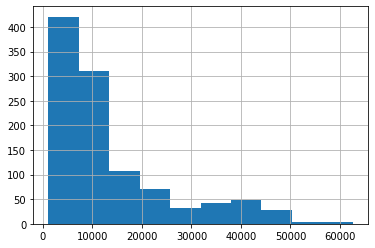

In [5]:
y_train['charges'].hist()

In [6]:
X_train.isnull().sum()

id          0
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
dtype: int64

In [7]:
X_test.isnull().sum()

id          0
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
dtype: int64

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1070 entries, 209 to 1140
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        1070 non-null   int64  
 1   age       1070 non-null   int64  
 2   sex       1070 non-null   int64  
 3   bmi       1070 non-null   float64
 4   children  1070 non-null   int64  
 5   smoker    1070 non-null   int64  
 6   region    1070 non-null   int64  
dtypes: float64(1), int64(6)
memory usage: 66.9 KB


In [9]:
X_train.select_dtypes("object").columns

Index([], dtype='object')

In [10]:
# Train ['sex', 'smoker', 'region']
cols = X_train.select_dtypes("object").columns

for col in cols:
    print("\n=====", col, "=====")
    print("[train]")
    print(X_train[col].value_counts())
    print("[test]")
    print(X_test[col].value_counts())

# Preprocessing

## Categorical Variables

In [11]:
X_train = pd.get_dummies(X_train, columns = cols)
X_test = pd.get_dummies(X_test, columns = cols)

In [12]:
X_train.head(2)

,id,age,sex,bmi,children,smoker,region
209,209,40,1,41.23,1,0,0
540,540,34,0,38.00,3,0,3


## Log Transform

<AxesSubplot:>

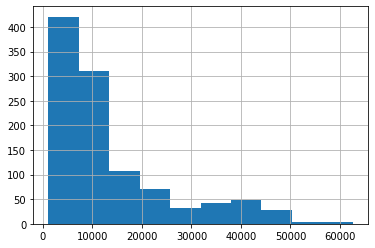

In [13]:
y_train['charges'].hist()

In [14]:
y_train['charges'] = np.log1p(y_train['charges'])

<AxesSubplot:>

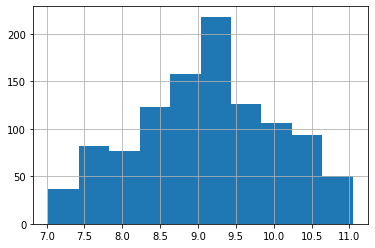

In [15]:
y_train['charges'].hist()

## Standard Scaler

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train['bmi'] = scaler.fit_transform(X_train[['bmi']])
X_test['bmi'] = scaler.transform(X_test[['bmi']])

## label encoding

In [17]:
# 나이를 10대, 20대, 30대로 구분하기 위해 10을 나눈 몫 값만 구함
X_train['age'] = X_train['age'].apply(lambda x: x//10)
X_test['age'] = X_test['age'].apply(lambda x: x//10)

In [18]:
X_train.head(3)

,id,age,sex,bmi,children,smoker,region
209,209,4,1,1.707232,1,0,0
540,540,3,0,1.180775,3,0,3
747,747,1,1,-1.466991,0,0,1


## Train-Validation Split

In [19]:
target = y_train['charges']
X_train = X_train.drop('id', 1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [20]:
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, target, test_size=0.15, random_state=2022)
X_tr.shape, X_val.shape, y_tr.shape, y_val.shape

((909, 6), (161, 6), (909,), (161,))

In [21]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_tr, y_tr)
pred = rf.predict(X_val)

In [22]:
from sklearn.metrics import mean_squared_error
def rmse2(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse2(y_val, pred)

0.37991620623466504

In [23]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true-y_pred)**2))

rmse(y_val, pred)

0.3799162062346651

In [24]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(X_tr, y_tr)
pred = xgb.predict(X_val)

In [25]:
rmse2(y_val, pred)

0.40211916758221516

In [26]:
rf.fit(X_train, y_train['charges'])
pred = rf.predict(X_test.drop('id',1))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [27]:
pred = np.exp(pred)
output = pd.DataFrame({'id': y_test['id'], 'charges':pred})
output.head()

,id,charges
1088,1088,9648.854086
1157,1157,4680.559592
1267,1267,33849.378763
506,506,3176.050802
659,659,12978.688647


In [ ]:
output.to_csv("000000.csv", index=False)

# 결과 체점

In [28]:
rmse(y_test['charges'], pred)

4807.265640025837